In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import listdir
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np 
import matplotlib.pyplot as plt # used for plotting training curves
from tensorflow.keras.applications import vgg16 # needed for bottom model
import seaborn as sn #import seaborn for heatmap
import pandas as pd #import pandas to aid in heatmap generation
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
model = tf.keras.applications.VGG16(weights = 'imagenet', # import VGG16 with pretrained weights
                    include_top = False,   # don't include top layers to allow for transfer learning with my own
                    input_shape= (224,224,3))

In [3]:
for layer in model.layers: #set all layers in VGG16 to be untrainable to utilize pretrained weights
    layer.trainable = False

In [4]:
# View imported vgg16 model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
# Define a function to add layers onto the imported vgg16 model

def add_layers(bottom_model):
    top_model = bottom_model.output
    top_model = Flatten()(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = Dense(3, activation='softmax')(top_model)
    return top_model

In [7]:
# Run function and combine preimported model with added layers

FC_Head = add_layers(model)

model = Model(inputs = model.input, outputs = FC_Head)

In [8]:
# View entire model with added layers

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
# Define directory where training data is stored

training_dir = 'split/train'

# Set up data generator for training data, normalize and use image augmentation to suppliment images

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range = 40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# use data generator to flow from directory into model at 224x224 px as required by VGG16

train_generator = train_datagen.flow_from_directory(training_dir,
                                                    batch_size=32,
                                                    target_size=(224,224))
# Define directory where test data is stored
test_dir = 'split/test'

# Set up data generator for normalizing test data
test_datagen = ImageDataGenerator(rescale=1.0/255)

# use data generator to flow from directory into model at 224x224 px as required by VGG16
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=32,
                                                  target_size=(224,224))

# Set up checkpoints to save best models based on validation loss during training
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',
                             monitor='val_loss',
                             verbose=0,save_best_only=True,
                             mode='auto')

Found 130046 images belonging to 3 classes.
Found 37160 images belonging to 3 classes.


In [10]:
# setup Adam optimizer using gradient clipping

opt_adam = tf.keras.optimizers.Adam(clipnorm=5.)

In [11]:
# Compile model using set up optimizer and categorical loss and accuracy metrics

model.compile(optimizer=opt_adam, loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [12]:
# Run model fitting using training_generator, for 5 epochs, using test_generator for validation and using checkpoint and early stopping callbacks

history = model.fit(train_generator,
                             epochs=5,
                             validation_data=test_generator,
                             callbacks=[checkpoint])

Epoch 1/5
4064/4064 [==============================] - 3502s 860ms/step - loss: 0.1458 - categorical_accuracy: 0.9459 - val_loss: 0.0467 - val_categorical_accuracy: 0.9845
INFO:tensorflow:Assets written to: model-001.model\assets
Epoch 2/5
4064/4064 [==============================] - 3477s 856ms/step - loss: 0.0834 - categorical_accuracy: 0.9704 - val_loss: 0.0252 - val_categorical_accuracy: 0.9910
INFO:tensorflow:Assets written to: model-002.model\assets
Epoch 3/5
4064/4064 [==============================] - 3298s 812ms/step - loss: 0.0697 - categorical_accuracy: 0.9758 - val_loss: 0.0222 - val_categorical_accuracy: 0.9931
INFO:tensorflow:Assets written to: model-003.model\assets
Epoch 4/5
4064/4064 [==============================] - 3169s 780ms/step - loss: 0.0615 - categorical_accuracy: 0.9787 - val_loss: 0.0202 - val_categorical_accuracy: 0.9929
INFO:tensorflow:Assets written to: model-004.model\assets
Epoch 5/5
4064/4064 [==============================] - 3230s 795ms/step - loss: 

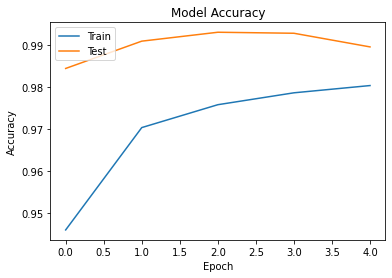

In [13]:
## Summarize accuracy and save as png

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.savefig('model_acc.png', dpi=200, format='png')

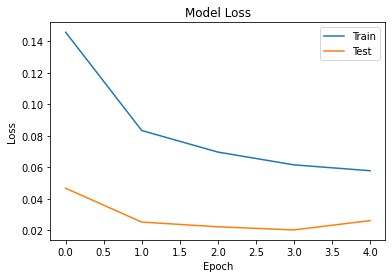

In [14]:
## Summarize loss and save as png

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper right')
plt.savefig('model_loss.png', dpi=200, format='png')

In [2]:
#model = load_model('model-004.model') #load best performing model from disk if not freshly trained and stored in memory

In [3]:
# Define directory where validation data is stored
val_dir = 'split/val'

# Set up data generator for normalizing validation data
val_datagen = ImageDataGenerator(rescale=1.0/255)

# use data generator to flow from directory into model at 224x224 px as required by VGG16
val_generator = val_datagen.flow_from_directory(val_dir,
                                                batch_size=32,
                                                target_size=(224,224),
                                                shuffle = False)

Found 18577 images belonging to 3 classes.


In [4]:
# Evaluate model using validation generator
model.evaluate(val_generator)

581/581 [==============================] - 269s 448ms/step - loss: 0.0232 - categorical_accuracy: 0.9921


[0.023235147818922997, 0.9921408295631409]

In [5]:
# Predict classes using validation generator
Y_pred = model.predict(val_generator)
# convert predictions into class labels
y_pred = np.argmax(Y_pred, axis=1)

In [6]:
# Run a confusion matrix based on predictions and expected labels
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))

# Run classification report on predictions and 
print('n/Classification Report')
target_names = ['correctly_worn', 'incorrectly_worn', 'no_mask']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[6697    7    0]
 [ 126 6537   10]
 [   0    3 5197]]
n/Classification Report
                  precision    recall  f1-score   support

  correctly_worn       0.98      1.00      0.99      6704
incorrectly_worn       1.00      0.98      0.99      6673
         no_mask       1.00      1.00      1.00      5200

        accuracy                           0.99     18577
       macro avg       0.99      0.99      0.99     18577
    weighted avg       0.99      0.99      0.99     18577



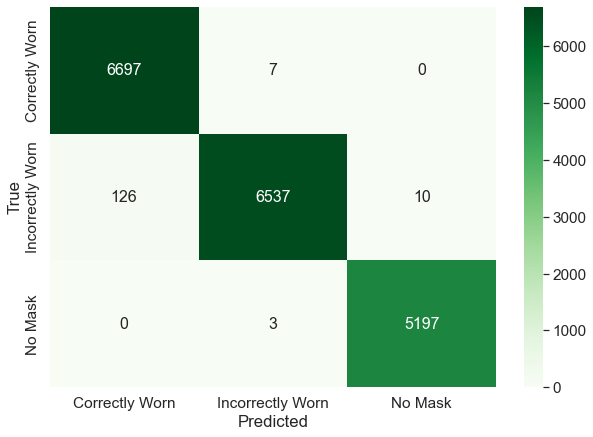

In [25]:
df_cm = pd.DataFrame(confusion_matrix(val_generator.classes, y_pred), index=['Correctly Worn', 'Incorrectly Worn', 'No Mask'], columns=['Correctly Worn', 'Incorrectly Worn', 'No Mask'])
plt.figure(figsize=(10,7)) # set plot size
sn.set(font_scale=1.4) # set font scale
ax = sn.heatmap(df_cm, annot=True, annot_kws={'size':16}, cmap='Greens', fmt='g') # create heatmap from confusion matrix
ax.set(xlabel='Predicted', ylabel='True') #label axis
plt.savefig('confusionmatrix.png', dpi=200, format='png') # save chart to disk